# Prediction of Travel Insurance 

# Introduction
In this notebook, we will develop and optimize a predictive model. Our goal is to build a model that predicts whether the person will buy a travel insurance or not. This prediction will determine whether there is a need to send an offer to a customer. The analysis includes exploratory data analysis, evaluating multiple models, identifying key features, and optimizing model performance to ensure robust and actionable insights.

## Objective:

**Model Selection**: We will compare various machine learning models to identify the most effective one for our prediction task. **Gradient Boosting** has been chosen as the final model due to its bests performance and abillity to generalize well.

**Feature Importance**: Understanding which features have the most influence on the model’s predictions is crucial. We will analyze feature importance to determine the key drivers behind the target variable and evaluate how these features contribute to the model’s performance.

**Performance Evaluation**: We will assess the performance of different models using metrics such as accuracy, recall, and precision. This involves tuning hyperparameters, moder ensembling.

## Recommendations on lowering the risk of stroke among people:
* pay more attention to elderly people. Age seems to be the most significant factor in the stroke outcome. Providing older people with mo


## Data Overview:

The dataset comprises nearly 2,000 rows. We identified and removed numerous duplicate entries based on the criteria detailed in the analysis.

Our dataset features a range of variables, including both continuous and binary types. Among these, the primary features deemed most influential for our model are AnnualIncome, Age, and FamilyMembers. Each of these variables has demonstrated a significant contribution to the model’s predictive performance.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import helper_functions
from typing import List
from zlib import crc32
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    GridSearchCV,
    train_test_split,
    cross_val_predict
)

### First look into the data

In [2]:
insurance_data = pd.read_csv("TravelInsurancePrediction.csv", index_col=0)

In [3]:
insurance_data.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [4]:
insurance_data.shape

(1987, 9)

In [5]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 155.2+ KB


In [6]:
len(insurance_data[insurance_data.duplicated()])

738

We have no missing values. Though, there are a lot of duplicates. Considering that none of the columns can be unique for the person, those duplicates are not necessarily the information about the same person. However, these duplicates can impact the model by introducing bias towards these repeated entries. Additionally, performing cross-validation without addressing duplicates will not provide an accurate assessment of the model's generalization performance, as the same entries could appear in both the training and test sets. Therefore, we have decided to drop these duplicates to ensure the integrity and reliability of our predictive modeling process. 

Before dropping, we will check the distribution of our target variable to make sure it is not changed.

In [7]:
insurance_data["TravelInsurance"].value_counts(normalize=True)

TravelInsurance
0    0.642677
1    0.357323
Name: proportion, dtype: float64

In [8]:
insurance_data = insurance_data[~insurance_data.duplicated()]
insurance_data["TravelInsurance"].value_counts(normalize=True)

TravelInsurance
0    0.613291
1    0.386709
Name: proportion, dtype: float64

In [9]:
insurance_data.shape

(1249, 9)

We see that the distribution is almost the same. Therefore, we will proceed with the dataset without duplicated entries

**Check predictor features**

In [10]:
insurance_data.describe()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1249.000000,1.249000e+03,1249.000000,1249.000000,1249.000000
mean,29.755805,9.345476e+05,4.890312,0.333066,0.386709
std,2.921039,3.607293e+05,1.762313,0.471499,0.487191
min,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,32.000000,1.200000e+06,6.000000,1.000000,1.000000
max,35.000000,1.800000e+06,9.000000,1.000000,1.000000


Among all of our numeric features, there are no outliers that have to be removed.

In [11]:
# check unique values in all the binary columns
binary_variables = ["Employment Type", "GraduateOrNot", 
                    "ChronicDiseases", "FrequentFlyer", 
                    "EverTravelledAbroad", "TravelInsurance"]
for column in binary_variables:
    print(f"{column}: ", insurance_data[column].unique())

Employment Type:  ['Government Sector' 'Private Sector/Self Employed']
GraduateOrNot:  ['Yes' 'No']
ChronicDiseases:  [1 0]
FrequentFlyer:  ['No' 'Yes']
EverTravelledAbroad:  ['No' 'Yes']
TravelInsurance:  [0 1]


Let's convert Yes/No object type columns to numeric type. 

In [12]:
encode_cat_var = ["GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"]
for column in encode_cat_var:
    insurance_data[column] = insurance_data[column].replace({"Yes": "1", "No": "0"})
    insurance_data[column] = insurance_data[column].astype("int")

**Before proceeding to Exploratory Data Analysis, let's split our dataset into train and test set. We will use stratified split to ensure the same distribution of the target variable**

In [13]:
train_set, test_set = train_test_split(insurance_data, random_state=0, 
                                       test_size=0.3,
                                       stratify=insurance_data["TravelInsurance"])

In [14]:
print(train_set.shape)
print(test_set.shape)

(874, 9)
(375, 9)


In [15]:
train_set["TravelInsurance"].value_counts(normalize=True)

TravelInsurance
0    0.613272
1    0.386728
Name: proportion, dtype: float64

The proportions are almost the same. Let's move to EDA

In [16]:
pd.merge(train_set, test_set, on=list(train_set.columns), how="inner")

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance


## Exploratory data analysis

### Univariate analysis

Let's analyze binary variables:
   * **Employment type**
   * **Graduated or not**
   * **Have chronic diseases**
   * **Is a frequent flyer**
   * **Have ever travelled abroad**
   * **Has travel insurance**

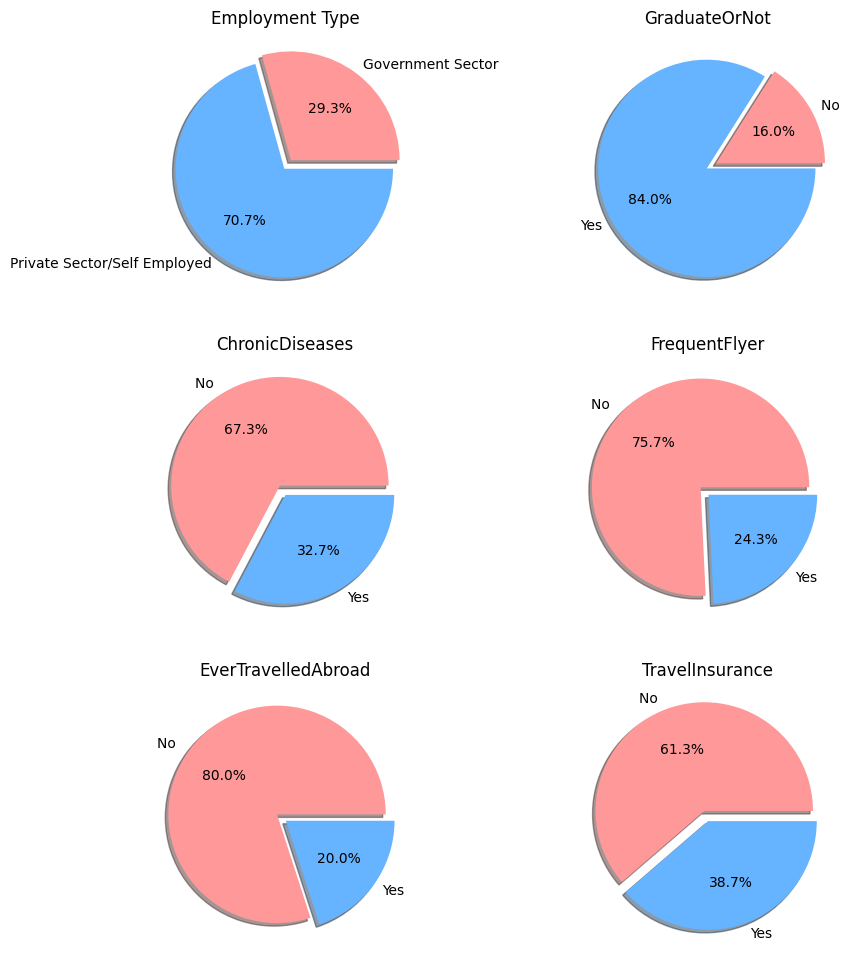

In [17]:
fig = plt.figure(figsize=(10, 12))
# for each column, plot the pie chart
for i, column in enumerate(binary_variables):
    # count values for each value
    type_count = train_set[column].value_counts().sort_index()
    ax = fig.add_subplot(3, 2, i+1)
    plt.title(column)
    # set the labels
    if column != "Employment Type":
        labels = ["Yes" if value == 1 else "No "
                  for value in type_count.index]
    else:
        labels = type_count.index
    ax.pie(type_count, shadow=True, 
           explode=(0.09, 0.01), autopct='%1.1f%%', 
           colors=['#ff9999', '#66b3ff'], labels=labels)

Around 70% of people are either self-employed or work in private sector. Majority of people have graduated from university(almost 85%). A little bit more than 30% percent of people have chronic diseases. What is interesting is that 80% of customers have never travelled abroad.

Let's dig into the other columns:
  * **Age**
  * **Annual Income**
  * **Number of family members**

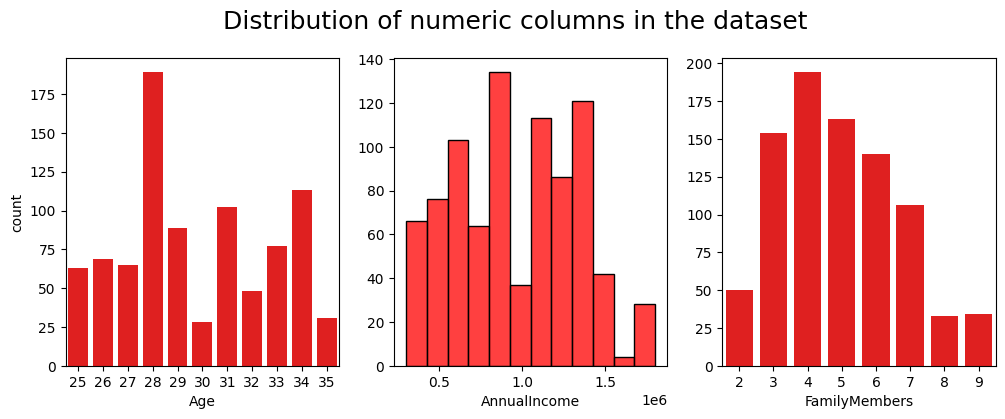

In [18]:
non_binary_col = ["Age", "AnnualIncome", "FamilyMembers"]
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, column in enumerate(non_binary_col):
    # histogram for AnnualIncome, barplot for other
    if column == "AnnualIncome":
        sns.histplot(x=column, data=train_set, color="red", ax=ax[i])
    else:
        sns.countplot(x=column, data=train_set, color="red", ax=ax[i])
    if i != 0:
        ax[i].set_ylabel("")
plt.suptitle("Distribution of numeric columns in the dataset", 
            fontsize=18, y=1);

We see that the age range of our customers is 25-35. The number of customers for each age is not distributed uniformly. Suprisingly, there are around two times more people aged 28 than any other age. The distribution of **annual income** is trimodal. This distribution doesn't have any significant outliers, meaning there are not customers which make way more than others. The number of family members ranges from 2 to 9. The distribution is close to normal with some right-skewness. Most of people have from 3 to 6 family members.

### Now, let's explore relationships between the target variable and the other predictors

We will:
   * Plot the distributions of each binary variable based on whether customers bought insurance.
   * Conduct a hypothesis test for each variable to assess the association.

**Null hypothesis**: There is no significant association between the binary variable and whether a customer bought insurance.

**Alternative hypothesis**: There is a significant association between the binary variable and whether a customer bought insurance.

**Significance level**: 5%

We will conduct chi-square test of independence. Before doing that, let's check whether the assumptions are met:
   * Although the Kaggle dataset does not explicitly state the sampling method used, we will assume that the data was obtained through Simple Random Sampling (SRS) for the purposes of our project.
   * Independence of observations. Assuming that Simple Random Sampling was used, the observations are supposed to be independent in our dataset.
   * The expected frequency count in each cell of the contingency table should be at least 5. For each test, we will check it separately.

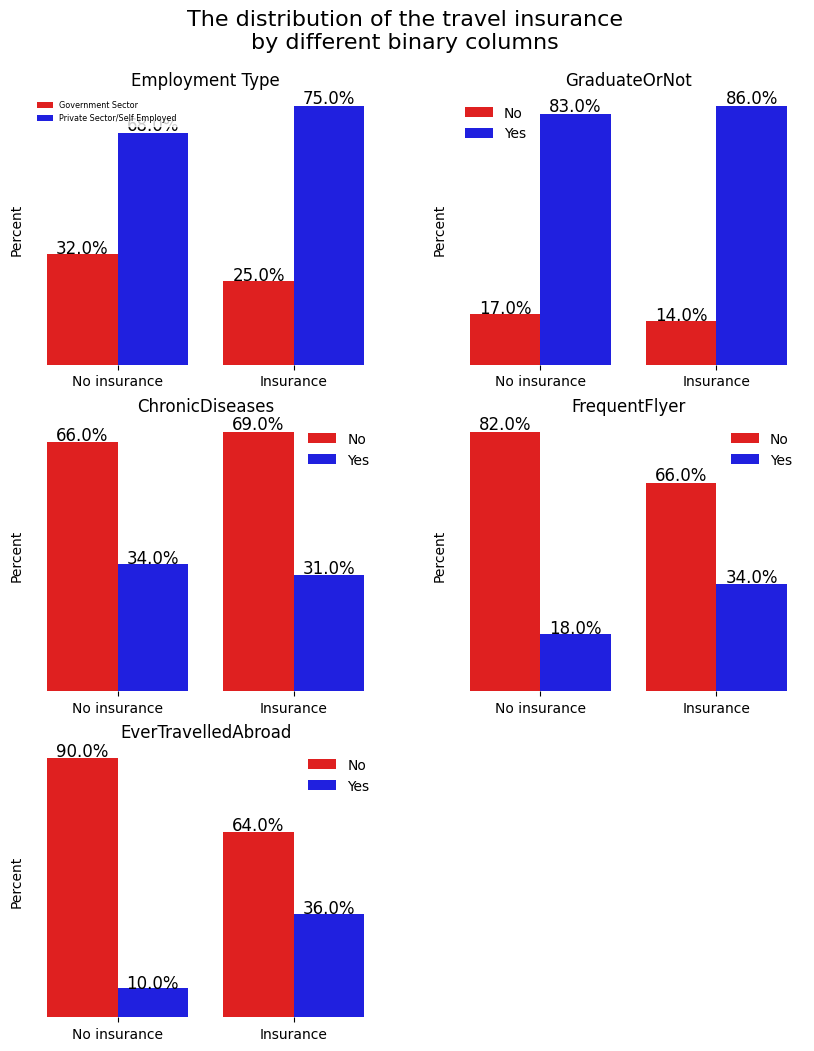

In [19]:
fig = plt.figure(figsize=(10, 12))
# create a dataset, where the tests results will be stored
test_res_df = pd.DataFrame(index=binary_variables[:-1], 
                           columns=["chi2", "p"])

for i, column in enumerate(binary_variables[:-1]):
    # count values in each group
    count = pd.crosstab(train_set['TravelInsurance'], train_set[column])
    
    # perform test
    chi2, p, _, exp = chi2_contingency(count)
    
    # check if expected values < 5
    if (exp < 5).any():
        print(f"The contigency table with {column} has frequency count < 5")
        
    # store the results in the DataFrame
    test_res_df.loc[column, 'chi2'] = chi2
    test_res_df.loc[column, 'p'] = p
    
    # calculate percentages and modify the shape for plotting
    count = count.apply(lambda x: x / x.sum(), axis=1).fillna(0)
    count = count.stack().reset_index()
    
    ax = fig.add_subplot(3, 2, i+1)
    sns.barplot(x="TravelInsurance", y=0, 
                hue=column, data=count,
               palette=["red", "blue"])
    sns.despine(left=True, bottom=True)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["No insurance", "Insurance"])
    ax.set_xlabel("")
    ax.set_ylabel("Percent")
    ax.set_title(column)
    ax.set_yticks([])
    helper_functions.customize_bar(position="v", axes=ax, pct=True)
    if column != "Employment Type":
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=["No", "Yes"], title="", 
              fontsize='medium', loc="best", edgecolor="white")
    else:
        ax.legend(title="", fontsize='xx-small', 
                  loc="best", edgecolor="white")
plt.suptitle("The distribution of the travel insurance\n"
             "by different binary columns", fontsize=16, y=0.95);

In [20]:
test_res_df

,chi2,p
Employment Type,5.597782,0.017983
GraduateOrNot,0.772709,0.37938
ChronicDiseases,0.570888,0.449906
FrequentFlyer,27.75828,0.0
EverTravelledAbroad,84.057801,0.0


Among those who have insurance, the percentage of individuals working it the private sector is higher compared to those who do not have insurance. However, The Chi-Square test yielded a statistically significant p-value below the 5% significance level, indicating an association between **Employment Type** and the likelihood of having insurance.

The same can't be said about **GraduateOrNot** and **ChronicDiseases** columns. There is no significant difference between each of these columns and the likelihood of having insurance.

**FrequentFlyer** and **EverTravelledAbroad** also showed statistically significant association between each of these columns and the outcome of buying an insurance. Individuals who travel abroad tend to purchase insurance more frequently. Similarly, customers who fly frequently are more likely to buy insurance. **EverTravelledAbroad** seems to have the highest association with out target variable.

**Let's check the assocaition between 3 other columns and the target variable**. Again, we will plot the distribution and conduct hypothesis tests.

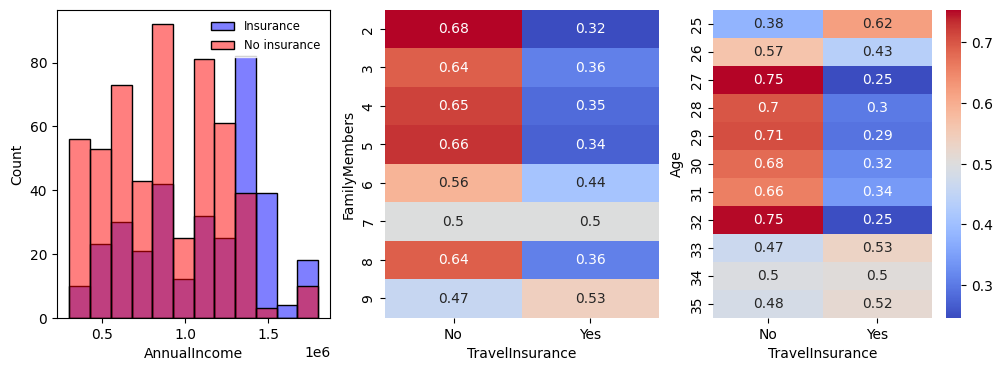

In [21]:
numeric_col = ["Age", "AnnualIncome", "FamilyMembers"]
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(hue="TravelInsurance", x="AnnualIncome", 
             ax=ax[0], data=train_set, palette=["red", "blue"])

ax[0].legend(labels=["Insurance", "No insurance"], title="", 
              fontsize='small', loc="best", edgecolor="white")

cross_family_members = pd.crosstab(train_set["FamilyMembers"],
                                train_set["TravelInsurance"])
pct_family_members = cross_family_members.apply(lambda x: x / x.sum(),
                                                axis=1).fillna(0)
sns.heatmap(pct_family_members, cmap="coolwarm", 
            annot=True, ax=ax[1], cbar=False)

cross_age = pd.crosstab(train_set["Age"],
                                train_set["TravelInsurance"])
pct_age = cross_age.apply(lambda x: x / x.sum(),
                                                axis=1).fillna(0)
sns.heatmap(pct_age, cmap="coolwarm", 
            annot=True, ax=ax[2]);

for axes in ax[1:]:
    axes.set_xticklabels(["No", "Yes"])

We see difference in **AnnualIncome** between those who bought insurance and those who didn't. People with an insurance make more money. We will conduct statistical test to find out whether the difference is significant.

There seems to be higher percent of people with insurance who have more **family members**.

The **Age** column yields interesting results. People who are the oldest(33-35) and the youngest(25-26) buy an insurance more often.

**Target population**: Customers from Tour & Travels Company.

**Hypothesis**: Is mean annual income of people who have insurance is significantly different from the mean annual income of peopl who don't have insurance.

**Null hypothesis**: Mean annual income of people who have insurance isn't significantly different from the mean annual income of peopl who don't have insurance.

**Alternative hypothesis**: Mean annual income of people who have insurance is significantly different from the mean annual income of peopl who don't have insurance.

**Significance level**: 5%.

Before conducting this test, let's check whether the assumptions are met:
  * The values follow a normal distributions or we have large enough sample size. In the plot above, we saw that the values don't follow normal distribution. Let's check the sample sizes

In [22]:
train_set.groupby("TravelInsurance").size()

TravelInsurance
0    536
1    338
dtype: int64

Our sample sizes are very large. Thus, we can apply Central Limit Theorem.

   * Independence. There is no unique identifier for each row which can assure us that all of the observations are unique. However, if we assume that the data was gathered using SRS, this assumptions will also hold

In [23]:
have_insurance = train_set[train_set["TravelInsurance"] == 1]
no_insurance = train_set[train_set["TravelInsurance"] == 0]

insurance_ci = (sm.stats.DescrStatsW(
    have_insurance['AnnualIncome']).zconfint_mean(alpha=0.05))

no_insurance_ci = (sm.stats.DescrStatsW(
    no_insurance['AnnualIncome']).zconfint_mean(alpha=0.05))
(insurance_ci, no_insurance_ci)

((1044629.6987670278, 1125488.6444282383),
 (827523.2878443348, 883670.7420064114))

95% percent Confidence Intervals don't intercept. Therefore, we reject the null hypothesis and conclude that there is statistically significant difference between annual income of people with and without insurance.

For **Age** and **FamilyMembers** columns, let's also perform chi-square test of independence.

**Target population**: Customers from Tour & Travels Company.

**Hypothesis**: Is there an association between the variable and the likelihood of buying an insurance.

**Null hypothesis**: There is no significant association between the variable and whether a customer bought insurance.

**Alternative hypothesis**: There is significant association between the variable and whether a customer bought insurance.

**Significance level**: 0.05.

In [24]:
chi_statistic, p, _, _ = chi2_contingency(cross_age)
chi_statistic, p

(50.34767373777723, 2.303494958631601e-07)

In [25]:
chi_statistic, p, _, _ = chi2_contingency(cross_family_members)
chi_statistic, p

(14.49915046315816, 0.042983156339165836)

Both p-value yielded statistically significant results. However, the p-value for FamilyMembers column is very close to 5%.

### Relationships between predictors

We will explore the following questions:
   * **Do people, who have graduated, have bigger annual income?**

   * **Is there difference between the annual income of a customer and his employment type?**

   * **Is there an association between chronic diseases and age?**

   * **Do people who travel abroad tend to fly more frequently?**

   * **Is there some association between annual income and age of a customer?**

   * **Is there a difference in annual income between those who travelled abroad and those who didn't??**

   * **Is there a difference in annual income between those who are frequent flyers and those who aren't??**

**Do people, who have graduated, have bigger annual income?**

In [26]:
train_set.groupby("GraduateOrNot")["AnnualIncome"].mean()

GraduateOrNot
0    857142.857143
1    960967.302452
Name: AnnualIncome, dtype: float64

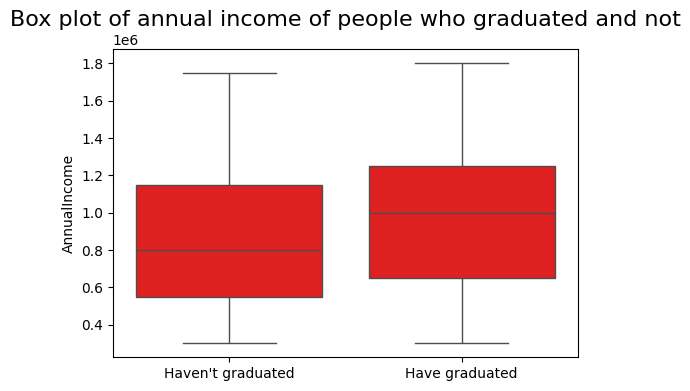

In [27]:
plt.figure(figsize=(6, 4))
ax = sns.boxplot(y="AnnualIncome", x="GraduateOrNot", 
                 data=train_set, color="red")
plt.title("Box plot of annual income of people who graduated and not",
         fontsize=16)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Haven't graduated", "Have graduated"])
plt.xlabel("");

The mean annual income and box plot analysis indicate that individuals who have graduated tend to earn slightly higher incomes compared to those who have not graduated. This suggests that graduation status could be an influencing factor in predicting the purchase of travel insurance, especially given the significant association observed between annual income and the target variable.

**Is there association between the amount of money a person makes and his employment type?**

In [28]:
train_set.groupby("Employment Type")["AnnualIncome"].mean()

Employment Type
Government Sector               8.070312e+05
Private Sector/Self Employed    1.001214e+06
Name: AnnualIncome, dtype: float64

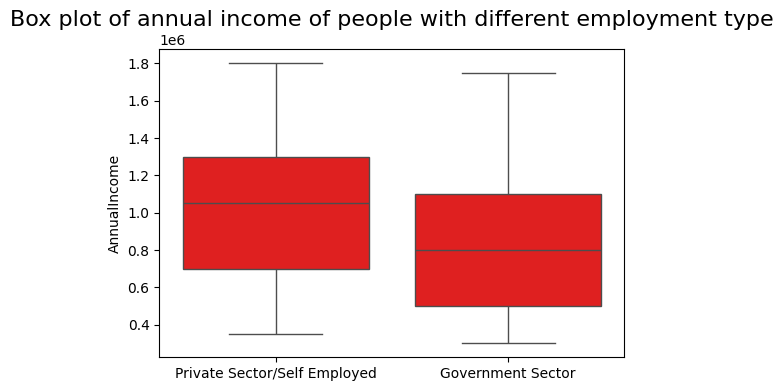

In [29]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="Employment Type", y="AnnualIncome", 
                 data=train_set, color="red")
plt.title("Box plot of annual income of people with different employment type",
         fontsize=16)
plt.xlabel("");

The analysis reveals an interesting correlation: individuals employed in the private sector tend to have higher annual incomes compared to those in other sectors. This correlation underscores the relationship between employment sector and income levels as significant predictors in the context of predicting travel insurance purchases.

**Is there a correlation between chronic diseases and age?**

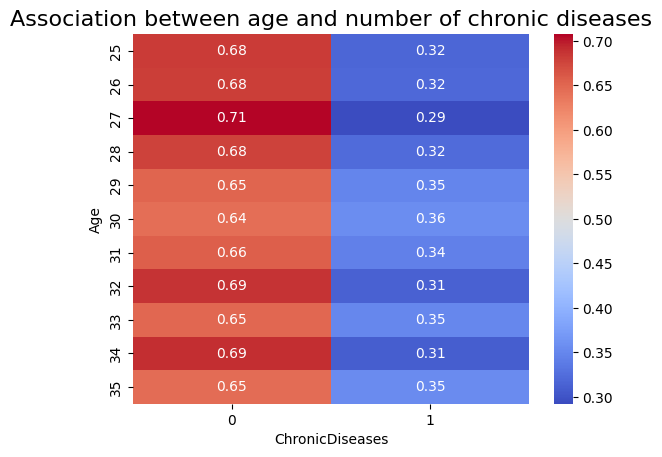

In [30]:
chr_dis_age_cross = pd.crosstab(train_set["Age"],train_set["ChronicDiseases"])
chr_dis_age = chr_dis_age_cross.apply(lambda x: x / x.sum(),
                                                axis=1).fillna(0)
sns.heatmap(chr_dis_age, cmap="coolwarm", 
            annot=True)
plt.title("Association between age and number of chronic diseases",
         fontsize=16);

We don't see any difference in age and the number of chronic diseases

**Do people who travel abroad tend to fly more frequently?**

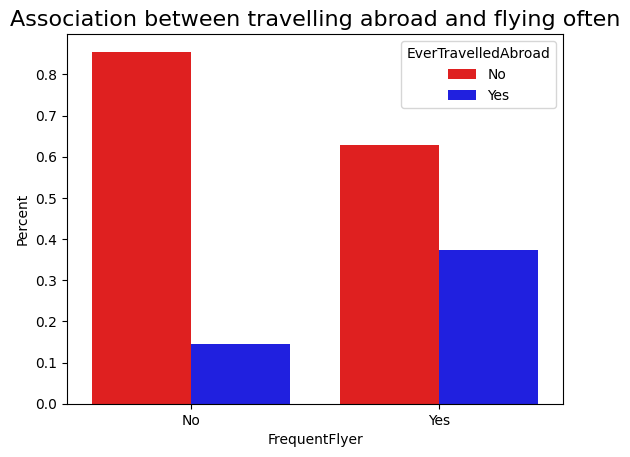

In [31]:
freq_fly_abroad = pd.crosstab(train_set["FrequentFlyer"],
                              train_set["EverTravelledAbroad"])
freq_fly_abroad = freq_fly_abroad.apply(lambda x: x / x.sum(),
                                                axis=1).fillna(0)
freq_fly_abroad = freq_fly_abroad.stack().reset_index()
ax = sns.barplot(x="FrequentFlyer", y=0, 
            hue="EverTravelledAbroad", data=freq_fly_abroad,
            palette=["red", "blue"])
ax.set_ylabel("Percent")
ax.set_xticks([0, 1])
ax.set_xticklabels(["No", "Yes"])
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["No", "Yes"], 
          title="EverTravelledAbroad")
plt.title("Association between travelling abroad and flying often",
         fontsize=16);

Here, the pattern is not suprising. People, who have travelled abroad are more often frequent flyers. To explore both of these predictors more, we will look into the assocciation of each of them with the annual income column:

**Is there a difference in annual income between those who travelled abroad and those who didn't?**

**Is there a difference in annual income between those who are frequent flyers and those who aren't?**

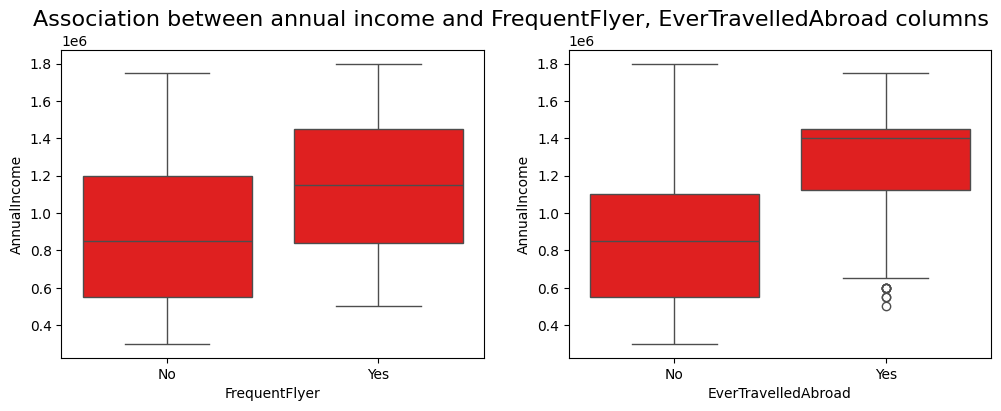

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x="FrequentFlyer", y="AnnualIncome", data=train_set, 
            ax=ax[0], color="red")
plt.suptitle("Association between annual income and"
             " FrequentFlyer, EverTravelledAbroad columns",
            fontsize=16)


sns.boxplot(x="EverTravelledAbroad", y="AnnualIncome", data=train_set, 
            ax=ax[1], color="red")

for axes in ax:
    axes.set_xticks([0, 1])
    axes.set_xticklabels(["No", "Yes"])

We see that people who fly frequently and those who have travelled abroad tend to make more money. This could indicate that annual income could be a better predictor of our feature than these variables. Let's also explore association of annual income with the age.

**Is there some association between annual income and age of a customer?**

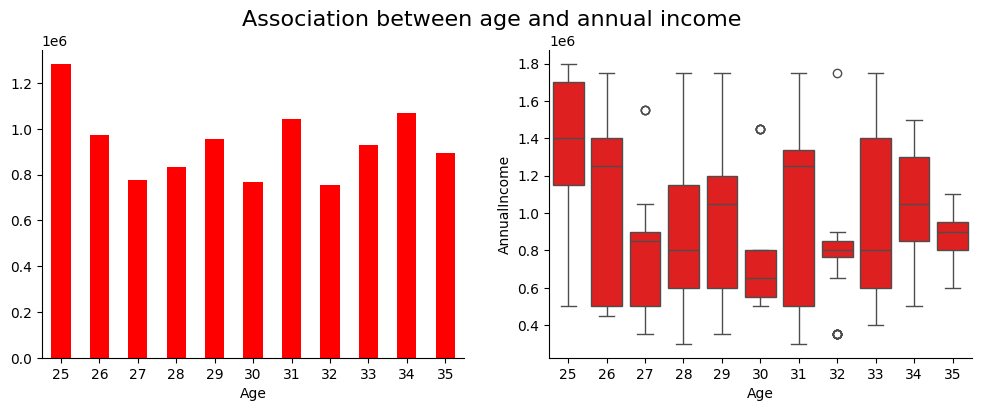

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
age_mean_income = train_set.groupby("Age")["AnnualIncome"].mean()
age_mean_income.plot(kind="bar", ax=ax[0], color="red")
ax[0].tick_params(axis="x", rotation=0)

plt.suptitle("Association between age and annual income", fontsize=16)
sns.boxplot(x="Age", y="AnnualIncome", data=train_set, 
            ax=ax[1], color="red")
sns.despine();

What has to be noted is that the youngest people tend to earn more(25-26 years old). In addition, those ages that make more money are exactly those who buy travel insurance more. This explain the pattern that we saw in the heatmap of age and travel insurance. This again, tells us that annual income may be a very useful predictor in our model.

To further explore the relationship between predictors and the TravelInsurance column, I propose binning the AnnualIncome column into 5 groups. This approach will allow us to investigate whether variables such as FrequentFlyer, EverTravelledAbroad, EmploymentType, etc., are associated with TravelInsurance under similar annual income conditions.

In [34]:
train_set.loc[:, "IncomeRange"] = pd.qcut(train_set.loc[:, "AnnualIncome"], 5)

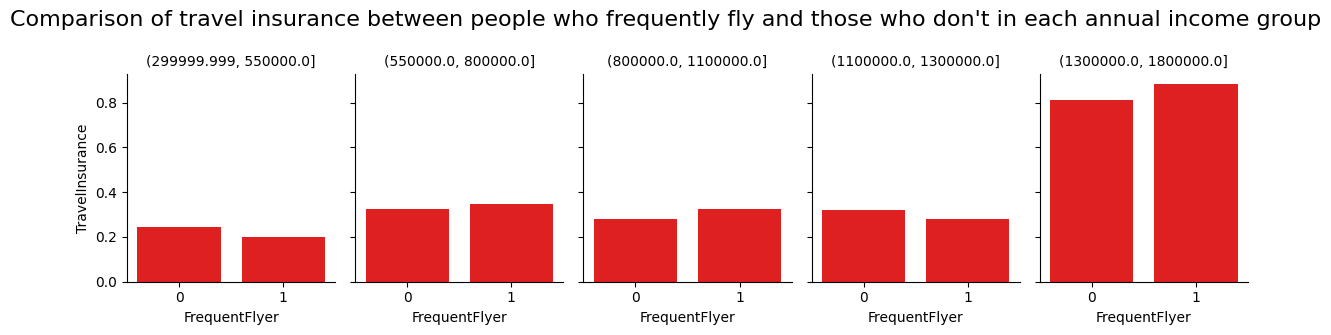

In [35]:
g = sns.catplot(data=train_set, col="IncomeRange",
            x="FrequentFlyer", y="TravelInsurance", kind="bar",
           errorbar=None, height=3, aspect=4/5, color="red")
g.set_titles("{col_name}")
g.fig.suptitle("Comparison of travel insurance between people"
               " who frequently fly and those who don't in"
               " each annual income group", y=1.1, fontsize=16);

It is noteworthy that among individuals with comparable income levels, there appears to be a balanced distribution between those with and without travel insurance in the FrequentFlyer category. 

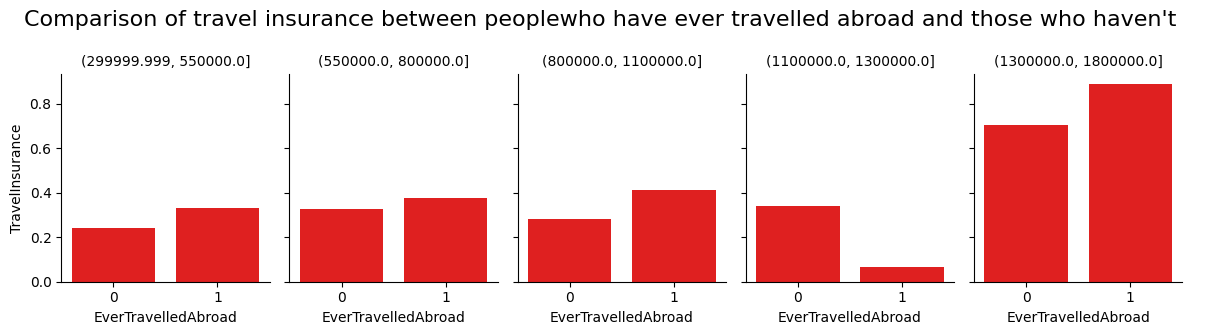

In [36]:
g = sns.catplot(data=train_set, col="IncomeRange",
            x="EverTravelledAbroad", y="TravelInsurance", kind="bar",
           errorbar=None, height=3, aspect=4/5, color="red")
g.set_titles("{col_name}")
g.fig.suptitle("Comparison of travel insurance between people"
               "who have ever travelled abroad and those who haven't",
               y=1.1, fontsize=16);

In most income groups, individuals with travel insurance who have traveled abroad are slightly more prevalent, though the difference is relatively minor. However, in the second-to-last income group, there is a notable exception: a significantly higher proportion of insured individuals have not traveled abroad compared to those who have.

This discrepancy suggests that the positive correlation between having travel insurance and having traveled abroad is either weak or negligible within similar income brackets.

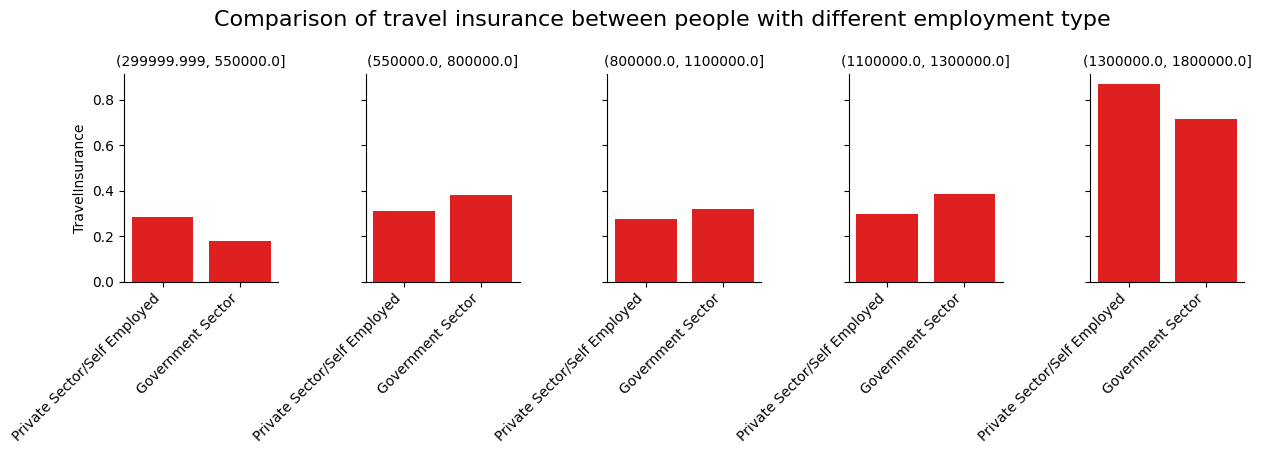

In [37]:
g = sns.catplot(data=train_set, col="IncomeRange",
            x="Employment Type", y="TravelInsurance", kind="bar",
           errorbar=None, height=3, aspect=4/5, color="red")
g.set_titles("{col_name}")
g.fig.suptitle("Comparison of travel insurance between people"
               " with different employment type", y=1.1, fontsize=16)
for ax in g.axes.flat:
    ax.set_xticks([0, 1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel("");

Here, we can see, again, that in the income groups that earn the most and the least, there is a little bit higher proportion of individuals who work in private sector and have travel insurance. While for those with the middle income there are more people with insurance who work in Government Sector.

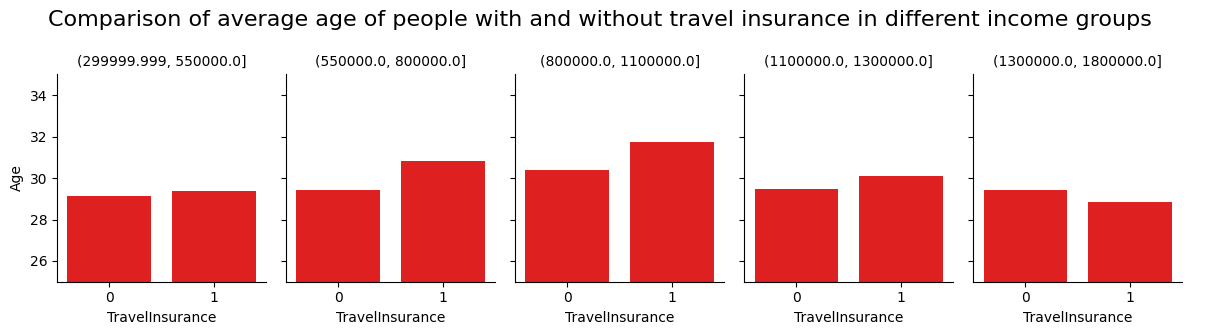

In [38]:
g = sns.catplot(data=train_set, col="IncomeRange",
            y="Age", x="TravelInsurance", kind="bar",
           errorbar=None, height=3, aspect=4/5, color="red")
g.set_titles("{col_name}")
g.set(ylim=(25, 35))
g.fig.suptitle("Comparison of average age of people with and without"
               " travel insurance in different income groups", 
               y=1.1, fontsize=16);

The average age is a little bit higher in a group with insurance in almost every group of annual income.

## Conclusion after Exploratory Data Analysis:
Our dataset comprises 8 columns, with the following characteristics:

   * Categorical Features: Seven out of eight columns are categorical. Of these, five are binary, while two (Age and Number of Family Members) are ordinal.
   * Continuous Feature: One column, Annual Income, is continuous.

### Key Observations:
   1. Dataset Size and Quality:
        * The dataset is relatively small, with approximately 2000 rows.
        * A significant number of rows are duplicates, which may affect the analysis and predictive modeling. Therefore, we made the decision to drop them.
   2. Binary Features and Target Association:
       * Out of the five binary features, three showed significant associations with the target variable (whether a person buys travel insurance):
           * Frequent Flyer: Frequent flyers are more likely to buy travel insurance.
           * Ever Travelled Abroad: Those who have traveled abroad tend to purchase travel insurance more often.
           * Employment Type: Individuals working in the private sector are more likely to buy insurance compared to those in the government sector.
       * It is worth noting the relationship between some features. Frequent flyers are often individuals who have traveled abroad, complicating the determination of which feature has a greater influence on the target variable.
   3. Continuous Feature (Annual Income):
       * Annual Income appears to be a strong predictor of the target variable. There is a statistically significant difference in Annual Income between those who buy travel insurance and those who do not.
       * Age also plays a role: within income groups, older individuals are more likely to buy insurance(except for the highest income group).
       * In addition, within similar income groups, the differences in travel insurance purchase outcomes among the Ever Travelled Abroad, Frequent Flyer, and Employment Type groups are minimal or nonexistent.
   4. Ordinal Features:
       * Age: Older individuals, especially those with higher incomes, are more inclined to purchase travel insurance.
       * Number of Family Members: There is a positive correlation between the number of family members and the likelihood of buying insurance.

## Data preparation

First of all, let's prepare our data for modelling part.

Drop the IncomeRange column:

In [39]:
train_set = train_set.drop(columns="IncomeRange")

Now, let's perfrom feature transformations:
   * Convert Employment Type feature into 0 and 1.
   * Standardize AnnualIncome, FamilyMembers and Age features.

In [40]:
encoder = OrdinalEncoder()
scaler = StandardScaler()
num_attr = ["AnnualIncome", "FamilyMembers", "Age"]

# create transformer; for other features, just pass it through
transform_columns = ColumnTransformer([
    ("scaler", scaler, num_attr),
    ("ord_encoder", encoder, ["Employment Type"])
],remainder="passthrough", force_int_remainder_cols=False)
X_train = transform_columns.fit_transform(train_set)


In [41]:
y_train = X_train[:, -1]
X_train = X_train[:, :-1]

In [42]:
# for future finding feature importance, get the 
# order of the transformed features
columns_order = []
for i in range(3):
    columns_order.extend(transform_columns.transformers_[i][2])
columns_order.pop();

In [43]:
X_train.shape

(874, 8)

In [44]:
y_train.shape

(874,)

### Predictive modelling

Our goal is to build a model that predicts whether a customer will purchase travel insurance based on their data. In this context, it is particularly important to minimize the number of False Negatives, thereby maximizing recall. The rationale behind this is the potential cost implications: if the model incorrectly predicts that a person will not buy insurance when, in reality, they would, it could lead to missed opportunities and financial losses.

We will try to use the following algorithms:

* **Logistic Regression**
* **K-nearest neighbours**
* **Decision Tree**
* **Random Forest**
* **Support Vector Machine(Linear, rbf kernel)**

Specify scoring metrics that we will use

In [45]:
scoring = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
cv = StratifiedKFold(n_splits=5)

**Logistic Regression**

Train the model

In [46]:
l_regr = LogisticRegression(C=1)
helper_functions.get_scores(l_regr, X_train, y_train)

{'accuracy': 0.7139588100686499,
 'recall': 0.4408284023668639,
 'precision': 0.7095238095238096,
 'f1': 0.5437956204379562}

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_train, l_regr.predict(X_train)))

              precision    recall  f1-score   support

         0.0       0.72      0.89      0.79       536
         1.0       0.71      0.44      0.54       338

    accuracy                           0.71       874
   macro avg       0.71      0.66      0.67       874
weighted avg       0.71      0.71      0.70       874



Cross-validation on cleaned data

In [48]:
log_scores = helper_functions.cross_val_scores(LogisticRegression(C=1), 
                                 X_train, y_train,
                                scoring=scoring, cv=cv)
log_scores.describe()

,accuracy,recall,precision,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.709346,0.443723,0.698348,0.540705,0.706160
std,0.025271,0.049574,0.066083,0.044089,0.038469
min,0.678161,0.373134,0.640000,0.471698,0.656336
25%,0.691429,0.411765,0.641026,0.533333,0.675687
50%,0.714286,0.470588,0.673469,0.542373,0.719557
75%,0.720000,0.470588,0.756757,0.568966,0.732863
max,0.742857,0.492537,0.780488,0.587156,0.746358


The baseline logistic regression model achieved an accuracy of 70% and a recall of approximately 44%. Through cross-validation, we determined that overfitting is not an issue for this model, as the training and validation scores are very similar.

**K-nearest neighbours**

Train the model

In [49]:
k_neighbours = KNeighborsClassifier()
helper_functions.get_scores(k_neighbours, X_train, y_train)

{'accuracy': 0.7871853546910755,
 'recall': 0.6005917159763313,
 'precision': 0.7992125984251969,
 'f1': 0.6858108108108109}

Cross-validation on cleaned data

In [50]:
knn_scores = helper_functions.cross_val_scores(KNeighborsClassifier(), 
                 X_train, y_train,
                scoring=scoring, cv=cv)
knn_scores.describe()

,accuracy,recall,precision,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.701353,0.508999,0.644096,0.567926,0.697853
std,0.037542,0.062653,0.062066,0.059408,0.038903
min,0.662857,0.426471,0.591837,0.495726,0.664720
25%,0.680000,0.477612,0.607143,0.537815,0.672141
50%,0.683908,0.500000,0.615385,0.548387,0.682104
75%,0.725714,0.558824,0.661017,0.619048,0.710005
max,0.754286,0.582090,0.745098,0.638655,0.760296


K-nearest neighbours model with n_neighbours=5 is overfitting. The difference in each of the scores is around 10%.

**Decision Tree**

Train the data

In [51]:
decision_tree = DecisionTreeClassifier(random_state=0)
helper_functions.get_scores(decision_tree, X_train, y_train)

{'accuracy': 0.9221967963386728,
 'recall': 0.7988165680473372,
 'precision': 1.0,
 'f1': 0.8881578947368421}

Cross-validation on cleaned data

In [52]:
decision_tree_scores = helper_functions.cross_val_scores(
    DecisionTreeClassifier(random_state=0), 
    X_train, y_train,
    scoring=scoring, cv=cv)
decision_tree_scores.describe()

,accuracy,recall,precision,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.607547,0.485338,0.492129,0.487643,0.585051
std,0.019303,0.058863,0.021937,0.038274,0.022281
min,0.582857,0.397059,0.465753,0.435484,0.567551
25%,0.600000,0.462687,0.482143,0.473282,0.572430
50%,0.603448,0.500000,0.484375,0.482270,0.572814
75%,0.617143,0.514706,0.507246,0.510949,0.590847
max,0.634286,0.552239,0.521127,0.536232,0.621614


Decision Tree model is overfitting even more, achieving 90% accuracy and perfect precision on the train data, while having around 60% accuracy on cross-validation.

**Random Forest**

Train the data

In [53]:
random_forest = RandomForestClassifier(random_state=0, 
                                       oob_score=metrics.recall_score)
print(helper_functions.get_scores(random_forest, X_train, y_train))
print(random_forest.oob_score_)

{'accuracy': 0.9221967963386728, 'recall': 0.8520710059171598, 'precision': 0.9411764705882353, 'f1': 0.8944099378881988}
0.5118343195266272


**Cross-validation on cleaned data**

In [54]:
forest_scores = helper_functions.cross_val_scores(
    RandomForestClassifier(random_state=0), 
    X_train, y_train, scoring=scoring, cv=cv)
forest_scores.describe()

,accuracy,recall,precision,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.680782,0.514925,0.601418,0.554436,0.651620
std,0.037294,0.061504,0.051965,0.056310,0.045790
min,0.628571,0.455882,0.525424,0.488189,0.596275
25%,0.662857,0.455882,0.584906,0.512397,0.630771
50%,0.683908,0.507463,0.607143,0.552846,0.635514
75%,0.702857,0.567164,0.622951,0.593750,0.684167
max,0.725714,0.588235,0.666667,0.625000,0.711374


The results are similar to decision tree model. Random Forest overfits a lot. In addition the accuracy on out-of-bag samples is 50%

**Linear Support Vector Machine**

Train the data

In [55]:
linear_svm = svm.LinearSVC(random_state=0)
helper_functions.get_scores(linear_svm, X_train, y_train)

{'accuracy': 0.7093821510297483,
 'recall': 0.42011834319526625,
 'precision': 0.71,
 'f1': 0.5278810408921933}

Cross-validation

In [56]:
linear_svm_scores = helper_functions.cross_val_scores(
    svm.LinearSVC(random_state=0), X_train, y_train, scoring=scoring, cv=cv)
linear_svm_scores.describe()

,accuracy,recall,precision,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.709333,0.428929,0.706928,0.532476,0.704759
std,0.031258,0.050677,0.077987,0.052943,0.038028
min,0.666667,0.358209,0.615385,0.452830,0.654137
25%,0.691429,0.397059,0.652174,0.524272,0.676524
50%,0.720000,0.441176,0.695652,0.526316,0.717633
75%,0.720000,0.470588,0.771429,0.566372,0.731343
max,0.748571,0.477612,0.800000,0.592593,0.744159


Linear Support Vector Machine shows very similar results to Logistic Regression. There is no overfitting. Plus, the accuracy is around 70%.

**Support Vector Machine - rbf**

Traing the data

In [57]:
rbf_svm = svm.SVC(random_state=0, kernel="rbf", C=1, gamma=0.1)
helper_functions.get_scores(rbf_svm, X_train, y_train)

{'accuracy': 0.7688787185354691,
 'recall': 0.5177514792899408,
 'precision': 0.8177570093457944,
 'f1': 0.6340579710144928}

Cross-validation

In [58]:
rbf_svm_scores = helper_functions.cross_val_scores(
    svm.SVC(random_state=0, kernel="rbf", C=1, gamma=0.1), 
    X_train, y_train, scoring=scoring, cv=cv)
rbf_svm_scores.describe()

,accuracy,recall,precision,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.747126,0.488104,0.776131,0.597369,0.740980
std,0.019755,0.058513,0.035494,0.045247,0.016517
min,0.725714,0.417910,0.727273,0.549020,0.719695
25%,0.735632,0.455882,0.750000,0.571429,0.731515
50%,0.742857,0.470588,0.794872,0.579439,0.742363
75%,0.754286,0.537313,0.800000,0.626087,0.748065
max,0.777143,0.558824,0.808511,0.660870,0.763263


Out of all the baseline models, Support Vector Machine with rbf kernel perfoms the best. We have 74% accuracy and 47% recall. No overfitting.

**Let's compare the scores of each model more**

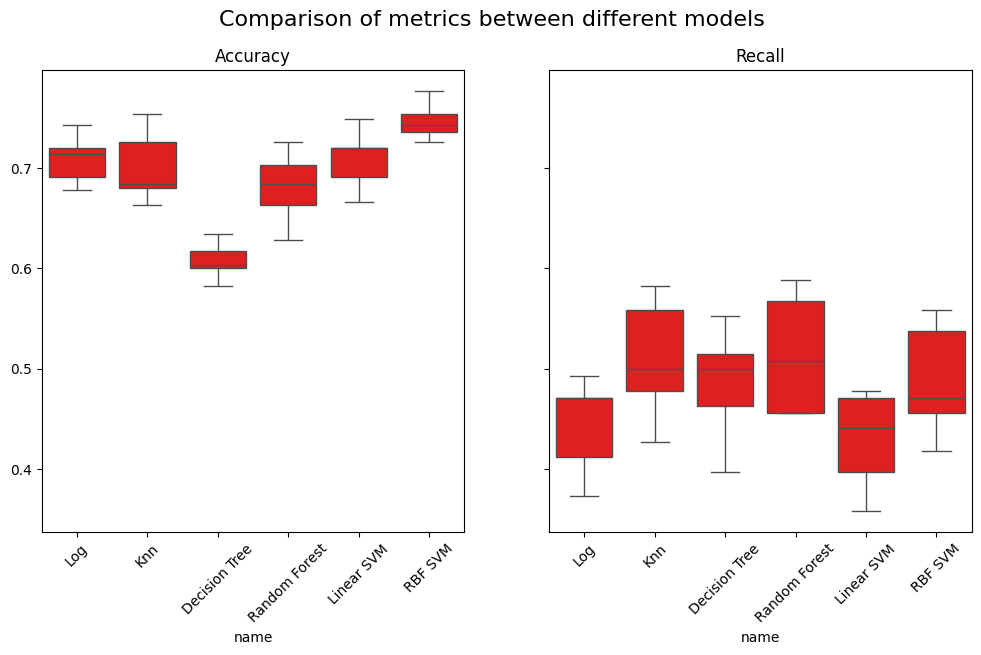

In [59]:
# concatentate all the scores in one dataframe
models_scores = [log_scores, knn_scores, decision_tree_scores,
                 forest_scores, linear_svm_scores, rbf_svm_scores]
all_results = pd.concat(models_scores, 
                        keys=["Log", "Knn", "Decision Tree",
                             "Random Forest", "Linear SVM",
                             "RBF SVM"])
# mark each part of the dataframe with the name of the model
all_results = all_results.reset_index().drop(columns="level_1")
all_results = all_results.rename(columns={"level_0": "name"})

# plot boxplots for accuracy and recall
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.suptitle("Comparison of metrics between different models",
         fontsize=16)
for axes in ax:
    axes.set_xticks([0, 1, 2, 3, 4, 5])
    axes.set_xticklabels(all_results["name"].unique(), rotation=45) 
sns.boxplot(x="name", y="accuracy", 
            data=all_results, ax=ax[0], color="red")
ax[0].set_ylabel("")
ax[0].set_title("Accuracy")

sns.boxplot(x="name", y="recall", 
            data=all_results, ax=ax[1], color="red")
ax[1].set_title("Recall");

Here, again, RBF SVM showed the highest accuracy. Linear SVM, Knn and Logistic Regression are a little bit worse. Random Forest and Decision Tree are one of the worst models in terms of accuracy. However, they showed higher recall. By using hyperparameter tuning on these algorithms, we could achieve more decent results. 

**Now, let's look at the confusion matrices**

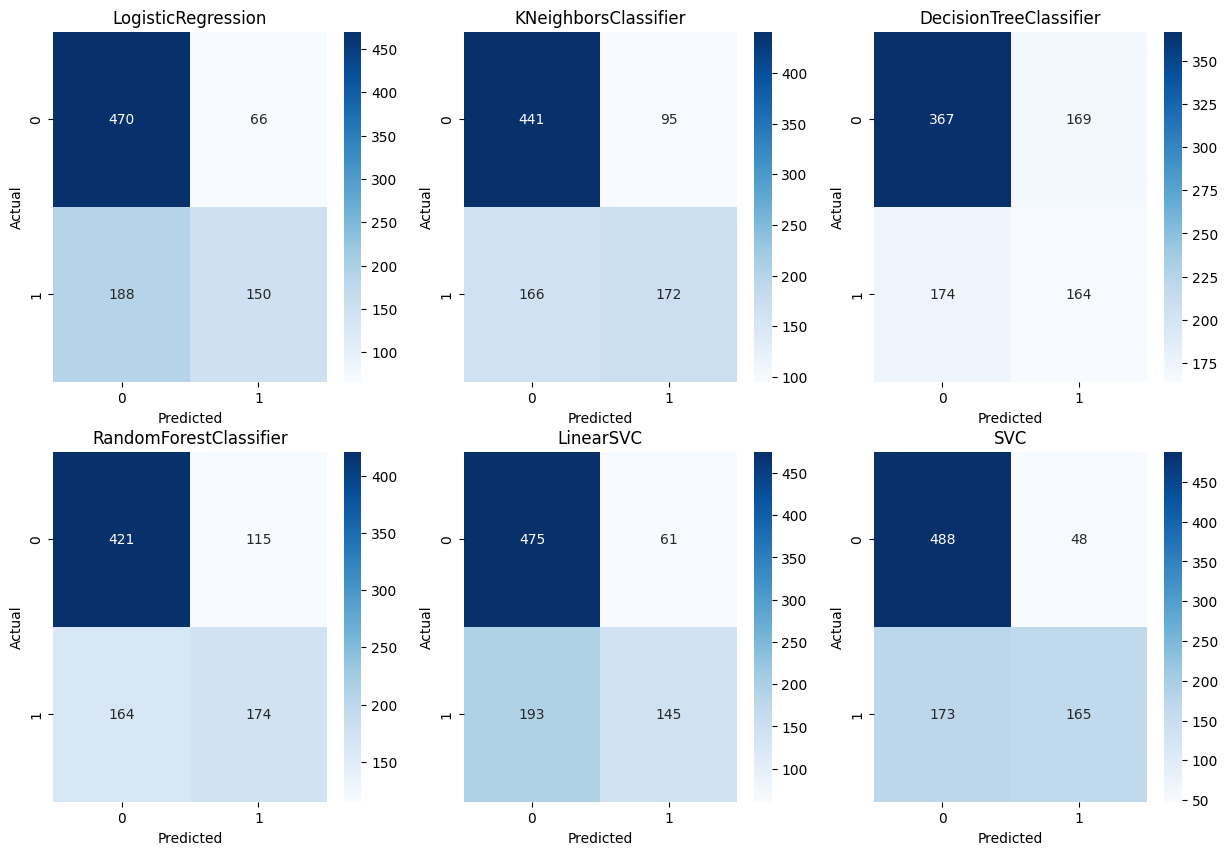

In [60]:
models = [LogisticRegression(C=1),
          KNeighborsClassifier(),
          DecisionTreeClassifier(random_state=0),
          RandomForestClassifier(random_state=0),
          svm.LinearSVC(random_state=0),
          svm.SVC(random_state=0, kernel="rbf", C=1, gamma=0.1)]
helper_functions.plot_confusion_matrices(models, X_train, 
                                         y_train, (15, 10))

We see that RandomForest is the best at minimizing False Negative. KNN is second best. Support Vector Machine with rbf kernel is showing the highest precision. Plus, its recall is one of the lowest

**So now, we will choose the following models and tune hyperparameters for them:**
   * RBF SVM
   * Random Forest
   * Decision Tree
   * K-nearest neighbour
   
To determine the best hyperparameters for our model, we will utilize GridSearch, with the Area Under the Curve (AUC) of the ROC curve as our performance metric. This choice is advantageous because AUC provides a comprehensive measure of the model's ability to distinguish between classes across all possible thresholds, ensuring that we select a model with robust overall performance. Additionally, by choosing the model with the highest AUC, we can further fine-tune the classification threshold to optimize recall, enhancing our ability to identify positive cases.

**Knn**

In [61]:
param_grid = {
    "n_neighbors": list(range(1, 31)),
    "weights": ["distance", None]
}
# try model with different parameters
# refit the model with the highest recall 
grid_search = GridSearchCV(KNeighborsClassifier(), 
                           param_grid, scoring=scoring,
                           cv=cv, refit="roc_auc")
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_
helper_functions.grid_search_results(grid_search, scoring, "roc_auc")

,mean,std
accuracy,0.74486,0.019202
recall,0.476558,0.051041
precision,0.779905,0.041784
f1,0.589629,0.041123
roc_auc,0.733713,0.03641


Average accuracy of the best k-nearest neighbours model is almost 75%, while the roc_auc is 0.73. 

**Decision Tree**

In [62]:
param_grid = {
    'max_depth': list(range(1, 11)),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ["balanced", None],
    'criterion': ["gini", "entropy"],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# try model with different parameters
# refit the model with the highest recall 
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=0), 
                           param_grid, scoring=scoring, 
                           refit="roc_auc", cv=cv)
grid_search.fit(X_train, y_train)
best_tree = grid_search.best_estimator_
helper_functions.grid_search_results(grid_search, scoring, "roc_auc")

,mean,std
accuracy,0.77575,0.028721
recall,0.491396,0.06017
precision,0.87359,0.04907
f1,0.627315,0.056771
roc_auc,0.74476,0.033538


This model shows better results: precision is around 88%. Accuracy is a bit higher: 0.78. Roc_auc is close to 0.75

**Random Forest**

In [62]:
param_grid = {
    'n_estimators': [100, 200],
    'max_features': [2, 4, 6, 8],
    'max_depth': [1, 2, 3, 4, 5, 6],
    'class_weight': ["balanced", None]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=0), 
                           param_grid, scoring=scoring, 
                           cv=cv, refit="roc_auc")
grid_search.fit(X_train, y_train)
best_forest = grid_search.best_estimator_
helper_functions.grid_search_results(grid_search, scoring, "roc_auc")

,mean,std
accuracy,0.780322,0.024117
recall,0.509043,0.042381
precision,0.870256,0.053879
f1,0.641394,0.041146
roc_auc,0.742708,0.022535


Random Forest model has just a bit higher accuracy and almost identical roc_auc

**RBF Support Vector Machine**

In [63]:
param_grid = {
    'C': [0.1, 1],
    'gamma': [0.01, 0.1, 1]
}
grid_search = GridSearchCV(svm.SVC(random_state=0, probability=True, 
                                   kernel="rbf", class_weight="balanced"), 
                           param_grid, scoring=scoring,
                           cv=cv, refit="roc_auc")
grid_search.fit(X_train, y_train)
best_svc = grid_search.best_estimator_
helper_functions.grid_search_results(grid_search, scoring, "roc_auc")

,mean,std
accuracy,0.743698,0.015224
recall,0.556321,0.057139
precision,0.717853,0.011602
f1,0.625198,0.035443
roc_auc,0.739062,0.021062


Support Vector Machine shows a bit lower accuracy than other models. However, the recall is the highest out of previous models.

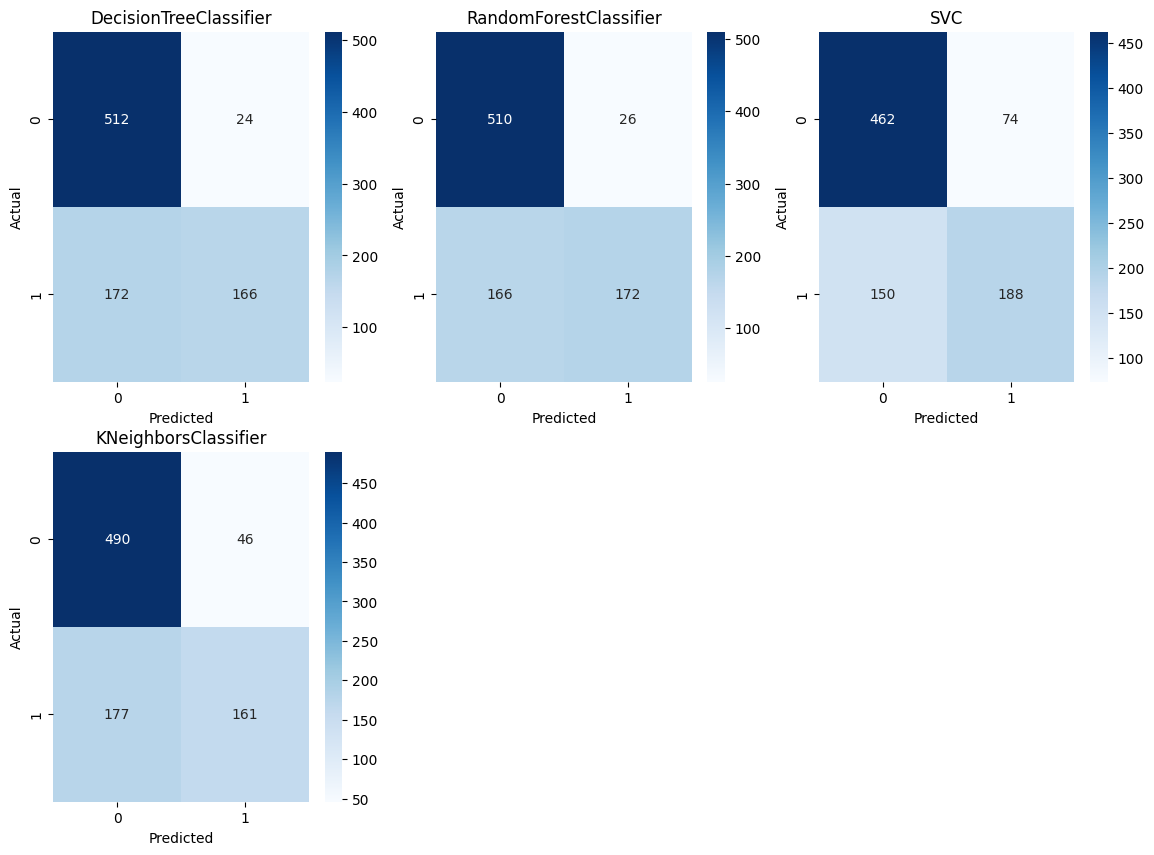

In [64]:
models = [DecisionTreeClassifier(**best_tree.get_params()),
         RandomForestClassifier(**best_forest.get_params()),
         svm.SVC(**best_svc.get_params()),
         KNeighborsClassifier(**best_knn.get_params())]
helper_functions.plot_confusion_matrices(models, X_train, y_train, (14, 10))

The Decision Tree and Random Forest models deliver nearly identical performance. The Decision Tree, however, has 6 more False Negatives but 2 fewer False Positives compared to the Random Forest. Meanwhile, the SVC with an RBF kernel exhibits the highest recall, but its precision is  the lowest compared to the other models. Given these observations, the **Decision Tree** stands out as our best model due to its competitive results and simplicity.

**To get even better results, let's try using boosting and bagging**

**First, let's use Voting Classifier with the following algorithms:**
* Random Forest
* RBF Support Vector Machine
* K-nearest neighbours
* Logistic Regression

In [65]:
voting_clf = VotingClassifier(
    estimators=[("tree", RandomForestClassifier()),
               ("rbf_svc", svm.SVC(kernel="rbf", probability=True)),
               ("knn", KNeighborsClassifier()),
               ("log", LogisticRegression())],
    n_jobs=-1, voting="soft")
voting_scores = helper_functions.cross_val_scores(voting_clf, 
                                                  X_train, 
                                                  y_train,
                                                  scoring=scoring, 
                                                  cv=cv)
voting_scores.describe()

,accuracy,recall,precision,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.747120,0.503029,0.763721,0.605004,0.691002
std,0.022923,0.055066,0.046067,0.044310,0.046493
min,0.720000,0.455882,0.711111,0.566372,0.637095
25%,0.729885,0.462687,0.738095,0.568807,0.661878
50%,0.748571,0.470588,0.745098,0.584906,0.688222
75%,0.760000,0.558824,0.808511,0.644068,0.709387
max,0.777143,0.567164,0.815789,0.660870,0.758430


This model isn't really different from best baseline models that we had. The accuracy is around 75%, while recall is very low - 50%

**Also, let's try boosting algorithms:**
* AdaBoost
* GradientBoosting

**AdaBoost**

In [66]:
ada_boost = AdaBoostClassifier(n_estimators=200, random_state=0,
                               algorithm="SAMME")
ada_scores = helper_functions.cross_val_scores(ada_boost, 
                                               X_train,
                                               y_train, 
                                               scoring, 
                                               cv)
ada_scores.describe()

,accuracy,recall,precision,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.739100,0.405312,0.847459,0.542263,0.732062
std,0.020956,0.076737,0.079413,0.063690,0.028068
min,0.712644,0.313433,0.756098,0.456522,0.687672
25%,0.731429,0.338235,0.785714,0.494624,0.725261
50%,0.731429,0.426471,0.840000,0.568807,0.738597
75%,0.754286,0.455882,0.920000,0.585859,0.747512
max,0.765714,0.492537,0.935484,0.605505,0.761270


The results here are very similar to the results of the Voting Classifier

**Gradient Boosting**

In [67]:
grad=GradientBoostingClassifier(random_state=0)
grad_boost_scores = helper_functions.cross_val_scores(grad, 
                                                      X_train,
                                                      y_train, 
                                                      scoring, 
                                                      cv)
grad_boost_scores.describe()

,accuracy,recall,precision,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.774588,0.520808,0.836111,0.641315,0.722342
std,0.032071,0.041207,0.074951,0.048773,0.028786
min,0.742857,0.485294,0.767442,0.594595,0.684236
25%,0.748571,0.492537,0.772727,0.607143,0.710830
50%,0.764368,0.500000,0.825000,0.616822,0.718527
75%,0.805714,0.544118,0.866667,0.691589,0.737062
max,0.811429,0.582090,0.948718,0.696429,0.761056


The result are better compared to previous models. 
Let's look closely at the confusion matrices:

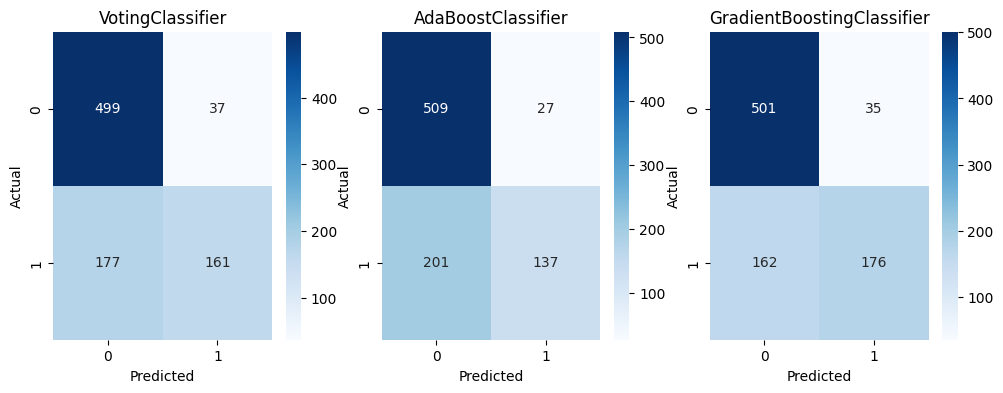

In [68]:
models = [VotingClassifier(estimators=[("tree", RandomForestClassifier()),
                                       ("rbf_svc", svm.SVC(kernel="rbf")),
                                       ("knn", KNeighborsClassifier()),
                                       ("log", LogisticRegression())],
                           n_jobs=-1), 
          AdaBoostClassifier(n_estimators=200, 
                             random_state=0, algorithm="SAMME"),
          GradientBoostingClassifier(random_state=0)]
helper_functions.plot_confusion_matrices(models, X_train, y_train, figsize=(12, 4))

Again, the results are very similar. Gradient boosting classifiers makes a few less False Negatives and has better accuracy.

**Let's tune hyperparameters for this model**

In [69]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'subsample': [0.25, 0.5, 1],
    'max_depth': [1, 2, 3, 4, 5]
}
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=0), 
                           param_grid, scoring=scoring, 
                           cv=cv, refit="roc_auc")
grid_search.fit(X_train, y_train)
grad_best = grid_search.best_estimator_
helper_functions.grid_search_results(grid_search, scoring, "roc_auc")

,mean,std
accuracy,0.780315,0.022498
recall,0.500088,0.034133
precision,0.880712,0.048472
f1,0.637581,0.03762
roc_auc,0.743112,0.032641


The results seem to be very similar to the results of the Decision Tree model. Let's compare:

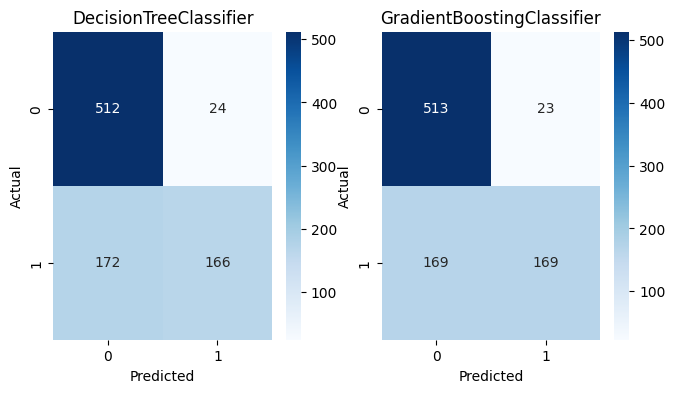

In [70]:
models = [DecisionTreeClassifier(**best_tree.get_params()),
         GradientBoostingClassifier(**grad_best.get_params())]
helper_functions.plot_confusion_matrices(models, X_train, y_train, figsize=(12, 4))

Indeed, results are almost identical. Before choosing the final model, let' also look at the accuracy, recall under different threshold values:

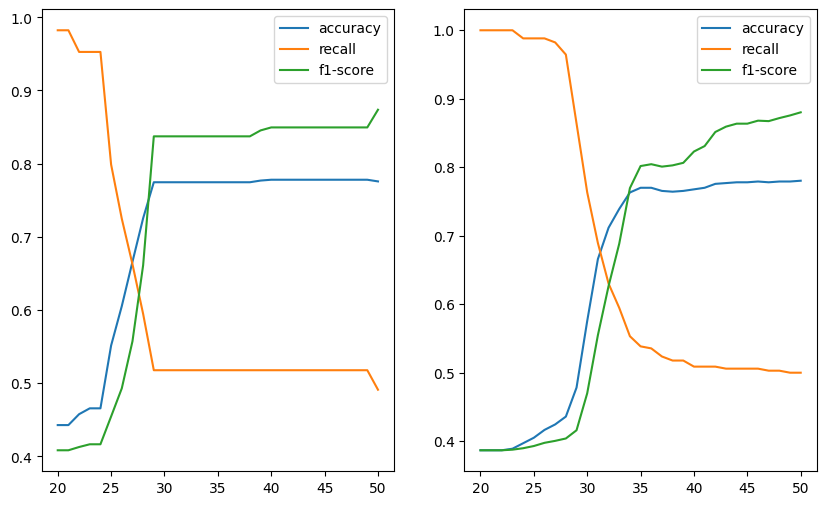

In [71]:
models = [DecisionTreeClassifier(**best_tree.get_params()),
         GradientBoostingClassifier(**grad_best.get_params())]

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
for i, model in enumerate(models):
    probas = cross_val_predict(model,
                X_train, y_train, cv=cv, method="predict_proba")
    probas = probas[:, 1]
    thresholds = list(range(20, 51))
    accuracy, recall, f1 = [], [], []
    for threshold in thresholds:
        threshold_results = (probas > threshold / 100).astype(int)
        accuracy.append(metrics.accuracy_score(y_train, threshold_results))
        recall.append(metrics.recall_score(y_train, threshold_results))
        f1.append(metrics.precision_score(y_train, threshold_results))
    sns.lineplot(x=thresholds, y=accuracy, label="accuracy", ax=ax[i])
    sns.lineplot(x=thresholds, y=recall, label="recall", ax=ax[i])
    sns.lineplot(x=thresholds, y=f1, label="f1-score", ax=ax[i])

We see very similar curves. However, the decision tree curve is a lot more bumpier. This indicates that by small adjustments of threshold, there may be huge adjustments in the score value. Gradient Boosting model has smooth curves. By using this model, we will be able to adjust threshold more easily and achieve better results. Therefore, despite Decision Tree being simpler model, we will stick to **Gradient Boosting** model.

In [72]:
final_model = GradientBoostingClassifier(**grad_best.get_params())
helper_functions.get_scores(final_model, X_train, y_train)

{'accuracy': 0.7848970251716247,
 'recall': np.float64(0.5088757396449705),
 'precision': np.float64(0.8865979381443299),
 'f1': np.float64(0.6466165413533834)}

**Let's look at the results on the test_set**

In [73]:
X_test = transform_columns.transform(test_set)
y_test = X_test[:, -1]
X_test = X_test[:, :-1]
X_test.shape

(375, 8)

In [74]:
helper_functions.get_scores(final_model, X_test, y_test, fit=False)

{'accuracy': 0.7573333333333333,
 'recall': np.float64(0.4413793103448276),
 'precision': np.float64(0.8648648648648649),
 'f1': np.float64(0.5844748858447488)}

The metrics on the test set show a decrease, with accuracy dropping by 3% and recall by 6%. This discrepancy suggests potential overfitting. Despite experimenting with various models and parameters, this remains the best result with the current data. To improve performance and better evaluate overfitting, acquiring additional data would be advantageous. Expanding the feature set could also contribute to better outcomes.

To enhance recall specifically, adjusting the threshold value based on the company’s business objectives is recommended. Fine-tuning this threshold can help align the model’s performance with the desired business goals.

**Lastly, let's look into feature importance of our best models**

In [75]:
models = [grad_best, best_forest, best_tree]
for model in models:
    name = str(model)
    name = name[:name.find("(")]
    print(name)
    for feature, importance in zip(columns_order,
                                   model.feature_importances_):
        print(feature, importance)
    print("----------------------------------------")

GradientBoostingClassifier
AnnualIncome 0.6283997765658649
FamilyMembers 0.19132177605285783
Age 0.15967315242939295
Employment Type 0.004382308943688385
GraduateOrNot 0.005924381868857263
ChronicDiseases 0.004089602886681593
FrequentFlyer 0.0043769845365536075
EverTravelledAbroad 0.0018320167161033647
----------------------------------------
RandomForestClassifier
AnnualIncome 0.6213884018793814
FamilyMembers 0.20173922806926822
Age 0.16889961338054185
Employment Type 0.0013409596865936498
GraduateOrNot 0.003796535247833337
ChronicDiseases 0.0012151313548129086
FrequentFlyer 0.0007042452803846434
EverTravelledAbroad 0.0009158851011840406
----------------------------------------
DecisionTreeClassifier
AnnualIncome 0.6185488848185634
FamilyMembers 0.23052633923866114
Age 0.13843797665070748
Employment Type 0.0
GraduateOrNot 0.006889693839851428
ChronicDiseases 0.005597105452216536
FrequentFlyer 0.0
EverTravelledAbroad 0.0
----------------------------------------


The analysis of feature importance across both models reveals the following key insights:

   * AnnualIncome: This feature is the most significant, contributing approximately 60% to the model’s predictions. Its high importance indicates a strong relationship with the target variable.
   * FamilyMembers: This feature accounts for around 20% of the model’s importance, showing that family size plays a notable role in the predictions.
   * Age: Contributing roughly 15%, Age also significantly impacts the model's output, though to a lesser extent than AnnualIncome and FamilyMembers.

The importance of these three features is consistent across all models, underscoring their critical role in predicting the target variable. In contrast, the binary features have negligible importance, close to 0%, suggesting they contribute minimally to the model’s predictive power.

This information highlights that focusing on AnnualIncome, FamilyMembers, and Age could be key to enhancing model performance and interpretability. Meanwhile, considering the low impact of the binary features, it may be beneficial to evaluate their relevance and possibly refine the feature set accordingly.

# Conclusion:

After thorough experimentation with various models and parameters, Gradient Boosting has emerged as the most effective approach for our task. The final model’s performance on the test set, though slightly lower than on the training set, is consistent with our best results given the available data.

### Key Findings:

**Feature Importance**:

   * AnnualIncome is the most influential feature, contributing approximately 60% to the model's predictions. Its dominant role highlights its strong association with the target variable.
   * FamilyMembers contributes around 20%, indicating that family size significantly impacts the model's predictions.
   * Age contributes approximately 15%, showing that age is also an important factor.
   
These findings are consistent across all tested models, reinforcing the importance of focusing on AnnualIncome, FamilyMembers, and Age. In contrast, the binary features have minimal impact, suggesting that they contribute little to the model's predictive power.

**Model Performance**:

The Gradient Boosting model has shown to be the best performer among the various models tested. While there is a slight decrease in metrics on the test set compared to the training set, this seems to be the best results with the available data.

**Recommendations for Improvement**:

   * Data Enhancement: Gathering additional data could further improve model performance and mitigate the signs of overfitting observed. More data can help the model learn more comprehensive patterns and improve its ability to generalize.
   * Feature Expansion: Adding and carefully selecting additional features might capture more relevant information, enhancing the model’s predictive power.
   * Threshold Adjustment: To optimize recall adjusting the classification threshold can help balance the trade-off between recall and precision.

By focusing on these areas, we aim to enhance the model's ability to generalize, achieve better performance on the test set, and meet the specific needs of the business.